In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import json
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/green_academy/data/filtered_custom_tmdb.csv')

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/green_academy/data/movie_posters_1_percent/'

In [ ]:
import shutil
shutil.rmtree(save_path)

In [ ]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [ ]:
def download_image(m_id, title, p_path):
    # title = title.replace(" ", "_")
    # title = title.replace("/", "_")
    if not os.path.exists(f"{save_path}{m_id}_{title}.png"):
        poster_base_url = "https://image.tmdb.org/t/p/w300"
        image_url = poster_base_url + p_path
        # Send a GET request to the image URL
        response = requests.get(image_url)
        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Open a file in binary write mode
            with open(f"{save_path}{int(m_id)}.png", "wb") as file:
                # Write the content of the response to the file
                file.write(response.content)

In [ ]:
for idx, row in tqdm(enumerate(df1.iterrows()), total=df1.shape[0]):
    # print(row[1]['poster_path'])
    if not pd.isna(row[1]['poster_path']):
        m_id = row[1]['id']
        title = row[1]['title']
        p_path = row[1]['poster_path']
        download_image(m_id, title, p_path)

100%|██████████| 4976/4976 [08:42<00:00,  9.52it/s]


In [ ]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [ ]:
path = save_path
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
posters = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            posters.append(file.name)

In [ ]:
len(posters)

4975

In [ ]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True, verbose=0)
    return features

553467096/553467096 [==============================] - 2s 0us/step


In [ ]:
data = {}
p = r"/content/drive/MyDrive/Colab Notebooks/green_academy/data/movie_posters_features.pkl"
for poster in tqdm(posters, desc="Extracting features"):
    try:
        features = extract_features(poster, model)
        data[poster] = features
    except Exception as e:
        with open(p,'wb') as file:
            pickle.dump(data,file)
        print(e)


# Saving the final data after loop completion
with open(p, 'wb') as file:
    pickle.dump(data, file)

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))


Extracting features: 100%|██████████| 4975/4975 [07:46<00:00, 10.67it/s]


In [ ]:
p = r"/content/drive/MyDrive/Colab Notebooks/green_academy/data/movie_posters_features.pkl"
#load data
with open(p, 'rb') as file:
    data = pickle.load(file)

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

In [ ]:
for n in np.arange(1000, 2000, 100):
    pca_temp = PCA(n_components=n, random_state=22)
    pca_temp.fit(feat)
    x = pca_temp.transform(feat)
    print(f"Components: {n}: {pca_temp.explained_variance_ratio_.sum()}")

Components: 1000: 0.911424994468689
Components: 1100: 0.9215676784515381
Components: 1200: 0.9305973052978516
Components: 1300: 0.9386330246925354
Components: 1400: 0.945797324180603
Components: 1500: 0.9522045254707336
Components: 1600: 0.9579504728317261
Components: 1700: 0.9631001353263855
Components: 1800: 0.9677116274833679
Components: 1900: 0.9718518257141113


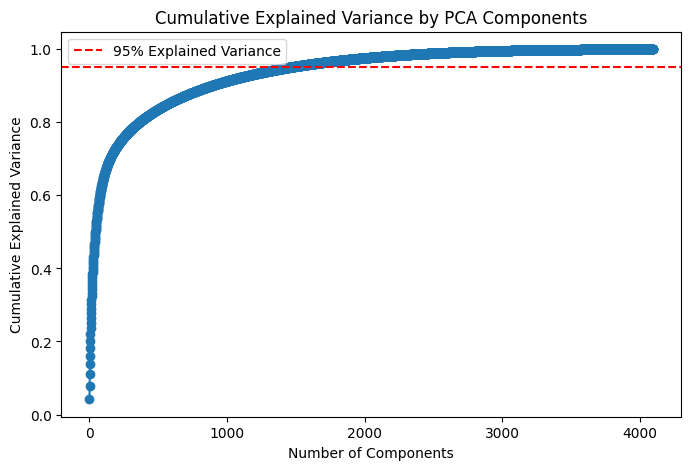

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca5 = PCA().fit(feat)  # Assuming 'data' is your dataset
cumulative_variance_ratio = pca5.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=0.95, linestyle='--', color='r', label='95% Explained Variance')
plt.legend()
plt.show()

In [ ]:
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

pca = PCA(n_components=0.95, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

Components before PCA: 4096
Components after PCA: 1448


In [ ]:
from sklearn.cluster import MiniBatchKMeans
sse = []


In [ ]:
list_k = list(np.arange(2, 20))

In [ ]:
# this is just incase you want to see which value for k might be the best

for k in tqdm(list_k, total=len(list_k)):
    km = MiniBatchKMeans(n_clusters=k, random_state=22, n_init=10, batch_size=100)
    km.fit(x)

    sse.append(km.inertia_)


100%|██████████| 18/18 [00:27<00:00,  1.54s/it]


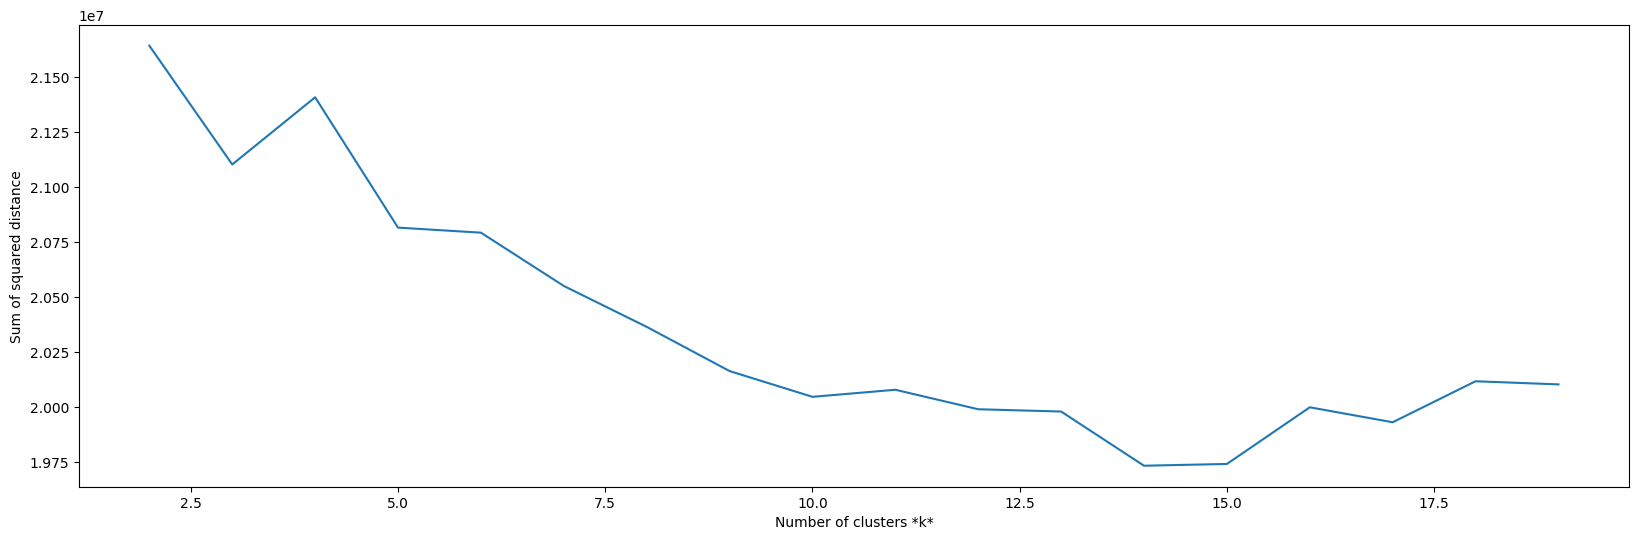

In [ ]:
# Plot sse against k
plt.figure(figsize=(20, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

In [ ]:
for k in tqdm(list_k, total=len(list_k)):
    km = MiniBatchKMeans(n_clusters=k, random_state=22, n_init=10, batch_size=100)
    km.fit(x)
    score = silhouette_score(x, km.labels_)
    silhouette_scores.append(score)


100%|██████████| 18/18 [00:39<00:00,  2.18s/it]


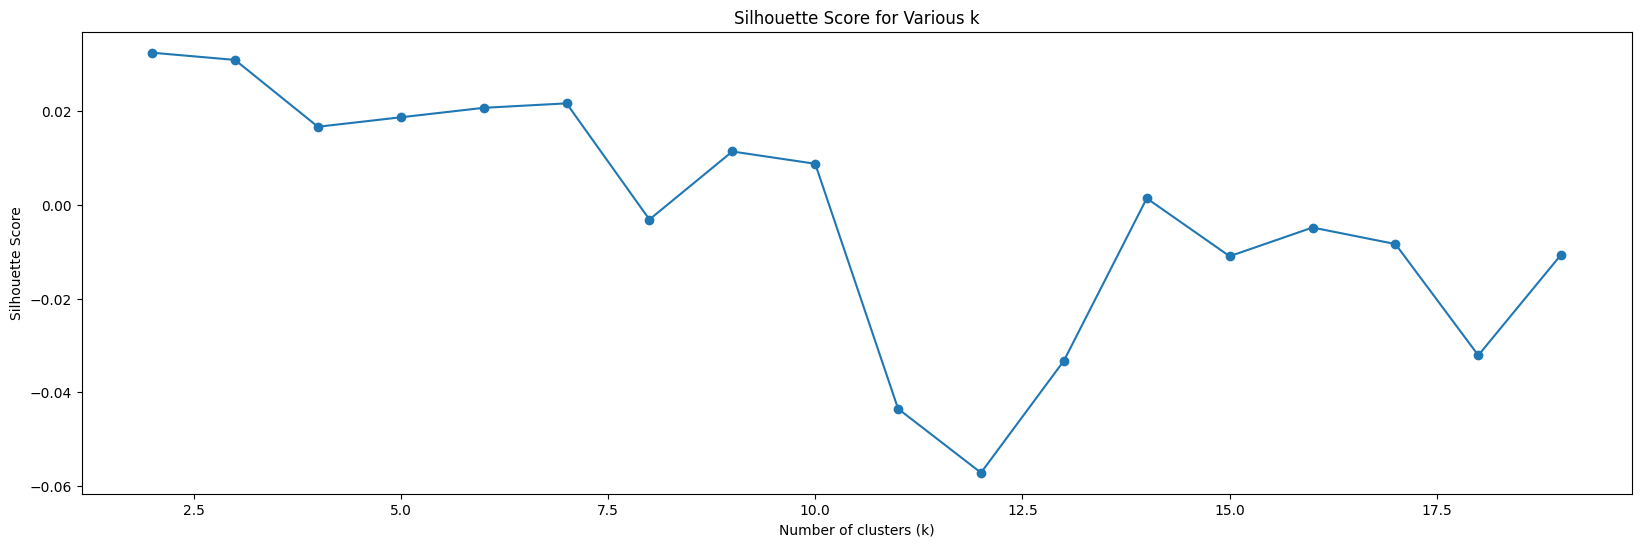

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(list_k, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Various k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(x)

KMeans(n_clusters=10, n_init=10, random_state=42)

In [ ]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

Cluster 5:



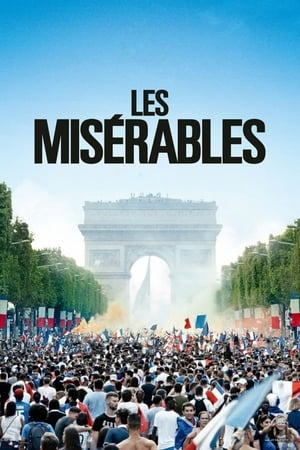
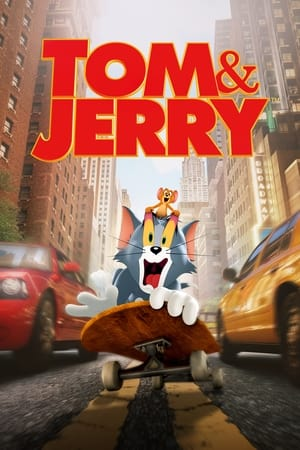
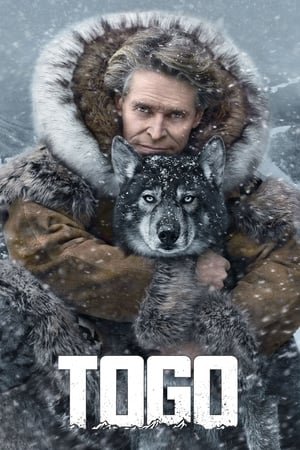
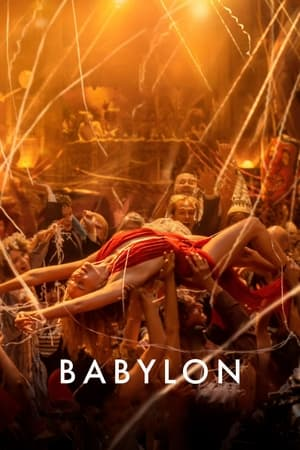
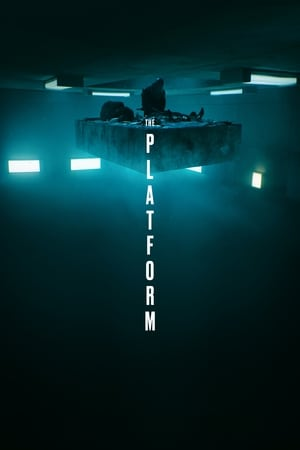

Cluster 6:



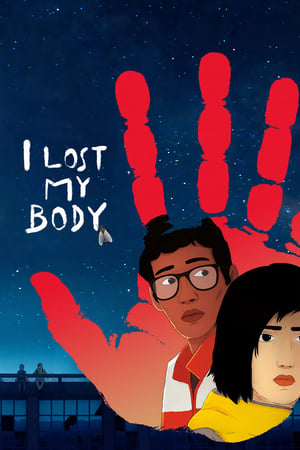
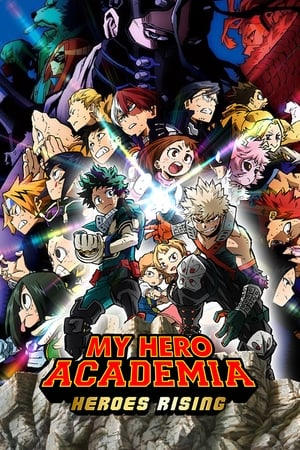
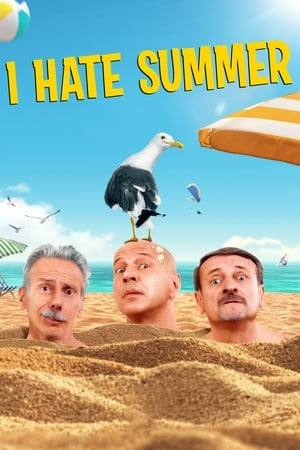
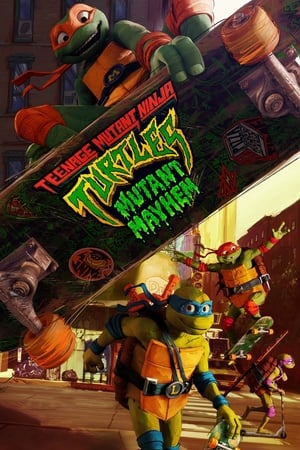
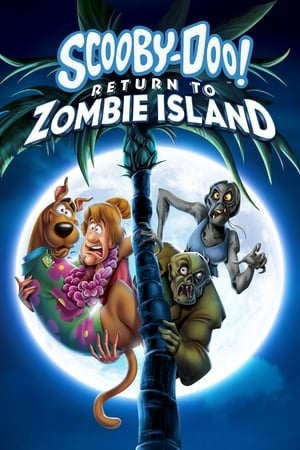

Cluster 3:



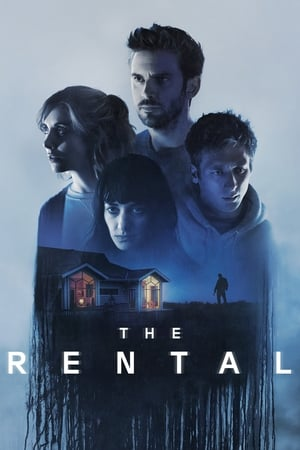
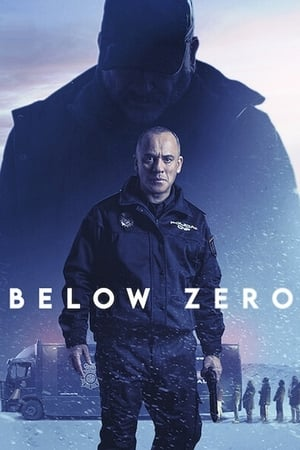
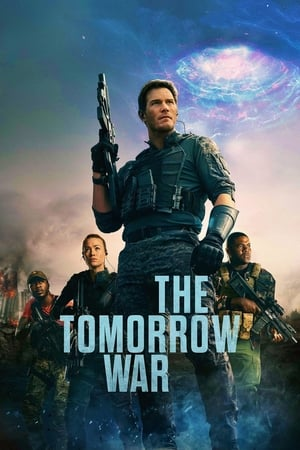
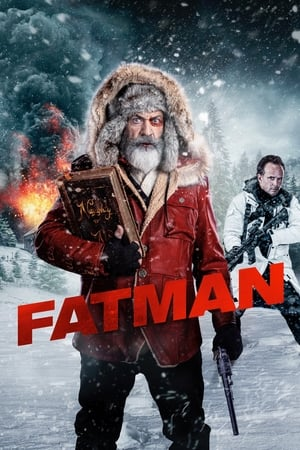
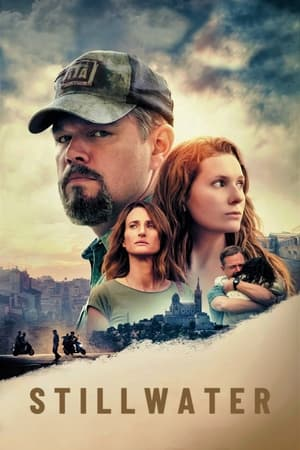

Cluster 1:



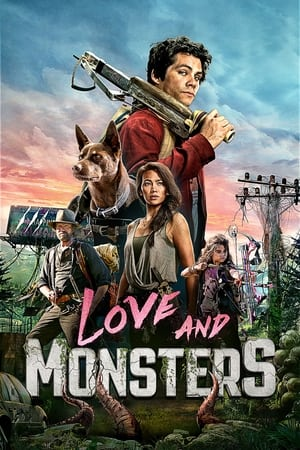
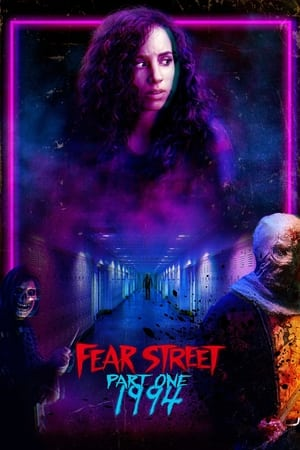
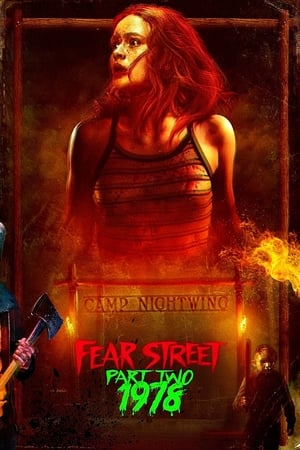
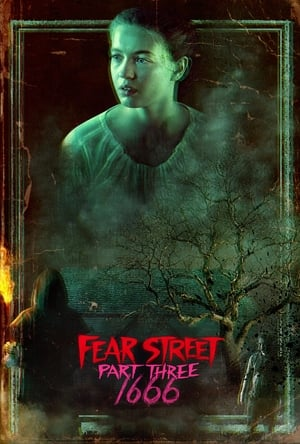
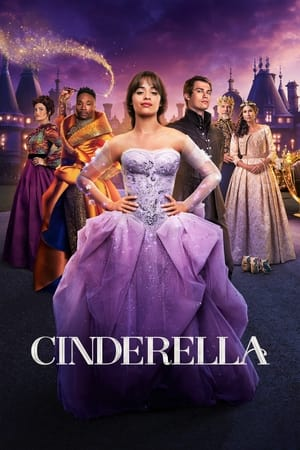

Cluster 7:



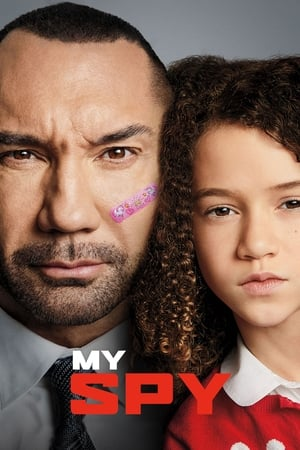
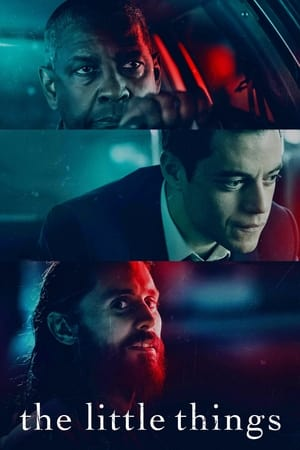
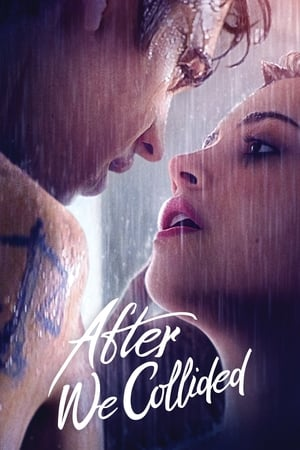
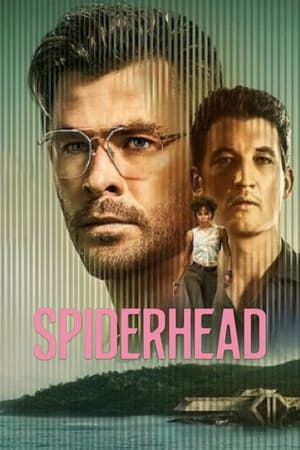
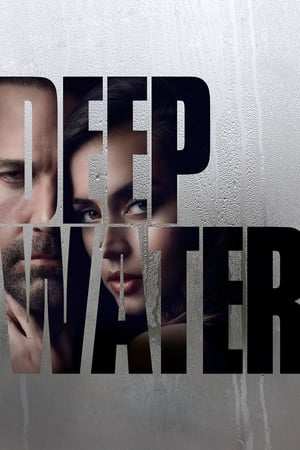

Cluster 9:



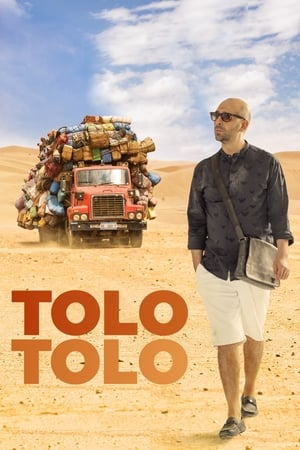
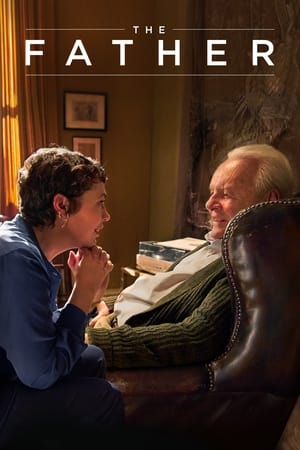
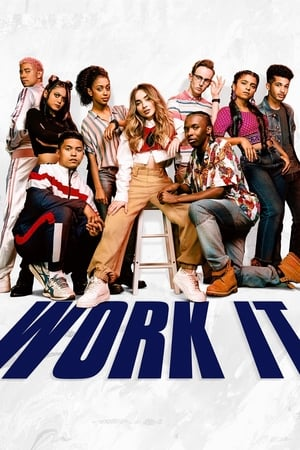
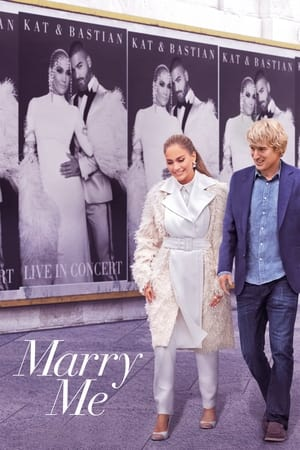
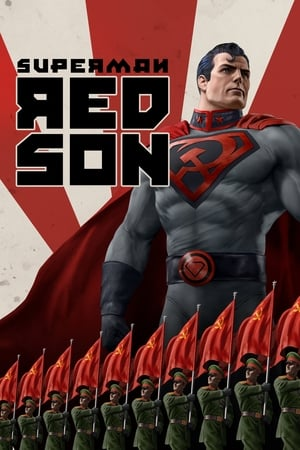

Cluster 2:



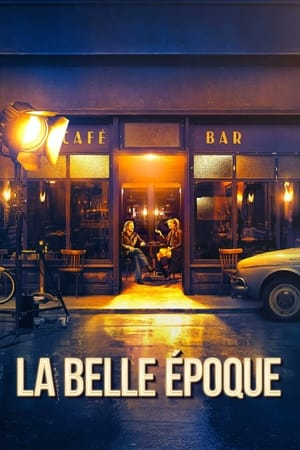
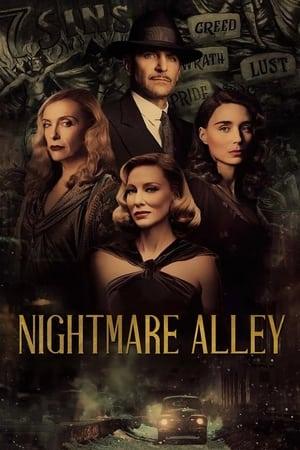
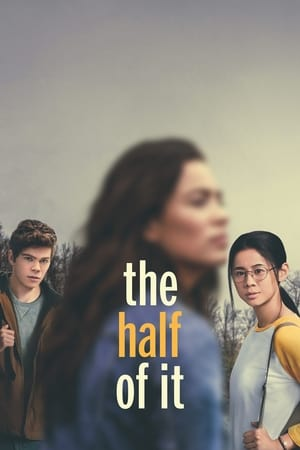
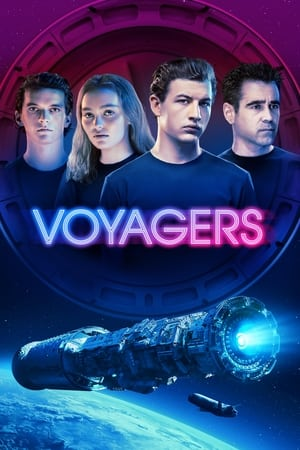
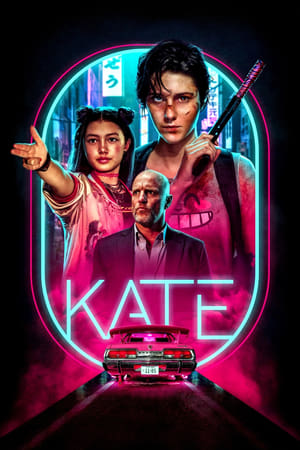

Cluster 8:



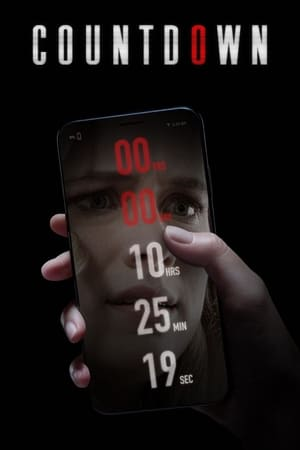
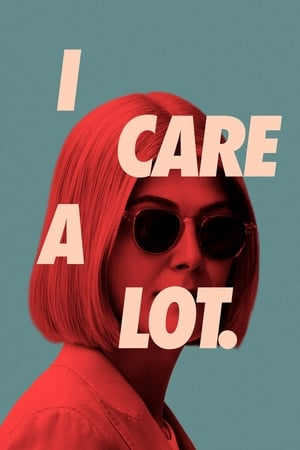
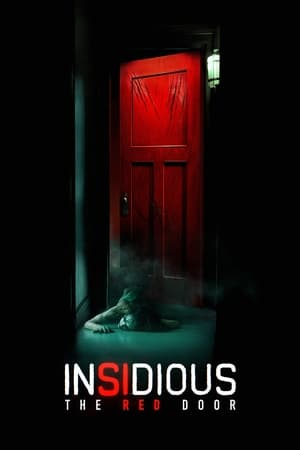
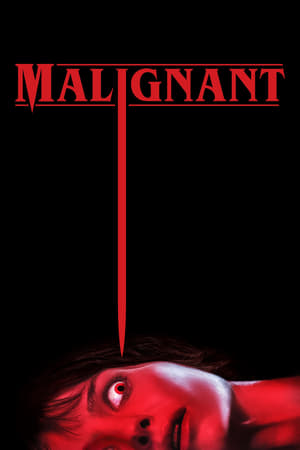
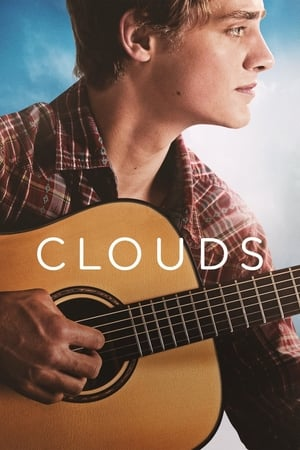

Cluster 4:



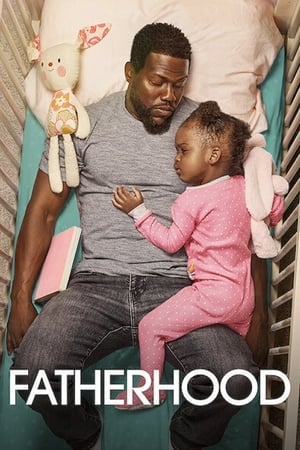
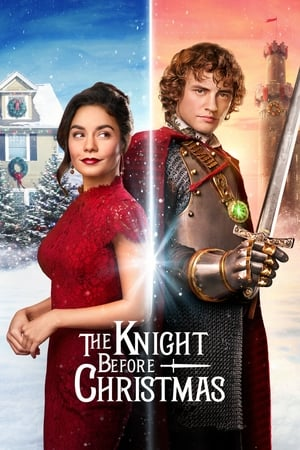
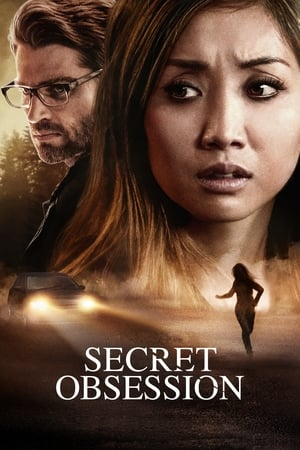
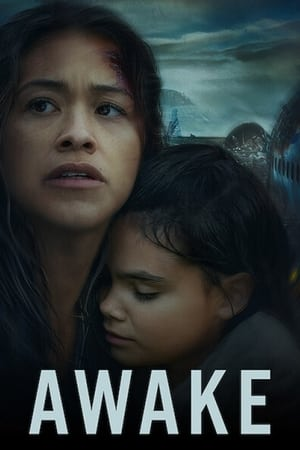
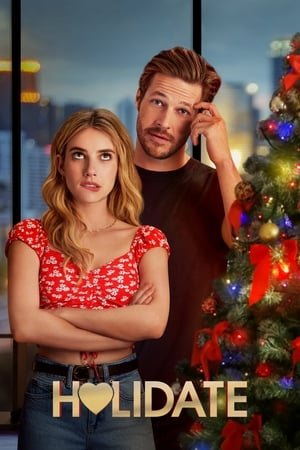

Cluster 0:



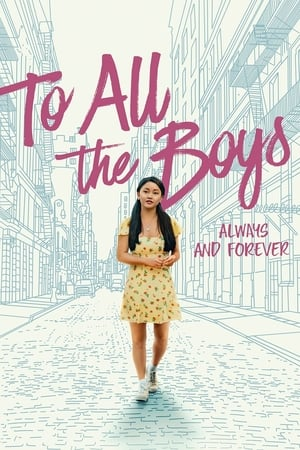
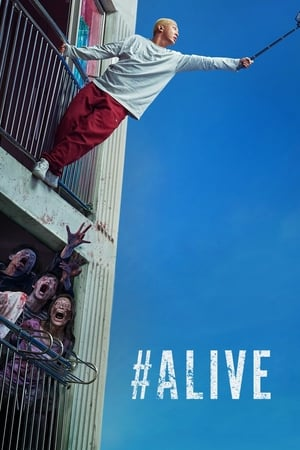
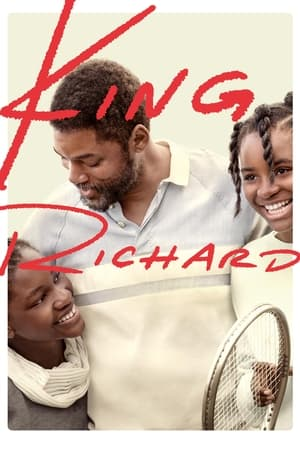
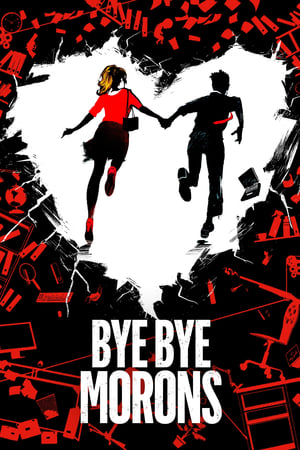
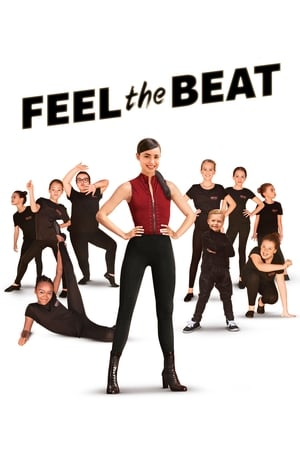

In [ ]:
from IPython.display import display, HTML
import os
import base64


# Adjust the width and height as needed
image_width = 100

# Display posters in a tiled layout, 5 per cluster
for cluster, files in groups.items():
    print(f"Cluster {cluster}:")
    # Create an HTML string for the images
    html_str = '<div style="display:flex; flex-wrap: wrap;">'
    for file in files[:5]:  # Adjust the number of posters to display per cluster
        file_path = os.path.join(save_path, file)
        if os.path.exists(file_path):
            with open(file_path, 'rb') as img_f:
                image = img_f.read()
            html_str += f'<img style="width:{image_width}px; margin:1px;" src="data:image/png;base64,{base64.b64encode(image).decode()}"/>'
    html_str += '</div>'
    display(HTML(html_str))

In [ ]:
import json

groups_str_keys = {str(k): v for k, v in groups.items()}

with open(r'/content/drive/MyDrive/Colab Notebooks/green_academy/data/poster_KM_dict.json', 'w') as f:
    json.dump(groups_str_keys, f)

In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np

def gaussian_similarity_matrix(X, sigma=None):
    """
    Compute the Gaussian (RBF) similarity matrix for a dataset X.

    Parameters:
    - X: numpy array of shape (n_samples, n_features)
    - sigma: float, the bandwidth of the RBF kernel. If None, it will be estimated.

    Returns:
    - S: numpy array of shape (n_samples, n_samples), the similarity matrix
    """
    # Compute the pairwise squared Euclidean distances
    pairwise_sq_dists = pairwise_distances(X, metric='sqeuclidean')

    # If sigma is not provided, estimate it as the mean distance
    if sigma is None:
        sigma = np.sqrt(0.5 * np.mean(pairwise_sq_dists))

    # Compute the similarity matrix
    S = np.exp(-pairwise_sq_dists / (2 * sigma**2))

    return S

similarity_matrix = gaussian_similarity_matrix(x)


In [ ]:
from sklearn.cluster import SpectralClustering
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh

# Compute the Laplacian of the similarity matrix
L = laplacian(similarity_matrix, normed=True)
# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(L)


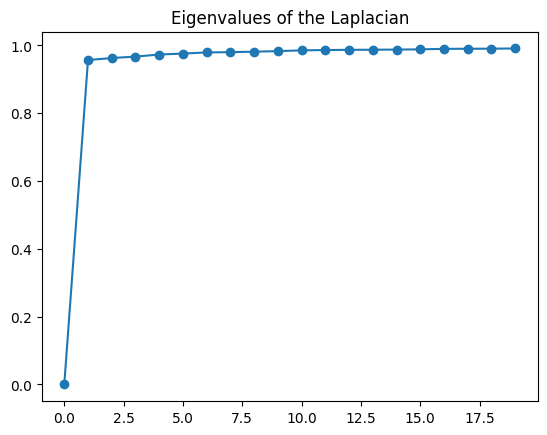

In [ ]:
# Plot the eigenvalues
plt.plot(eigenvalues[:20], 'o-')
plt.title('Eigenvalues of the Laplacian')
plt.show()

# Look for the largest gap in the eigenvalues to determine k

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(2, 20)  # Adjust based on computational resources and dataset size

for k in K_range:
    spectral = SpectralClustering(n_clusters=k, random_state=22, n_init=10)
    labels = spectral.fit_predict(x)  # Assuming feat_reduced is your PCA-reduced dataset
    score = silhouette_score(x, labels)
    silhouette_scores.append(score)


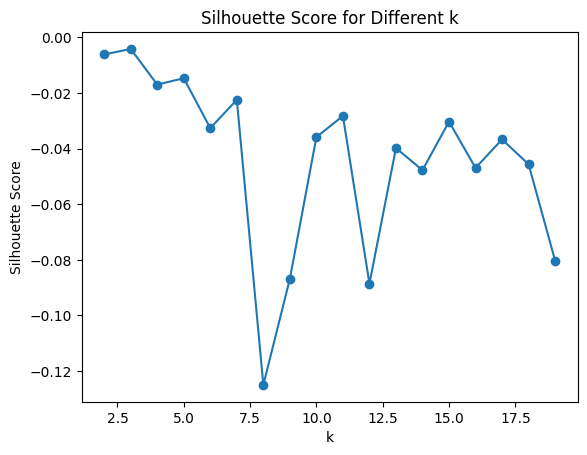

In [ ]:
# Plot silhouette scores
plt.plot(K_range, silhouette_scores, 'o-')
plt.title('Silhouette Score for Different k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
from sklearn.cluster import SpectralClustering

# Assuming you've decided on a number of clusters k after analysis
k = 10  # Example, adjust based on your criteria

spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=22)
labels_spectral = spectral.fit_predict(x)

# Now, labels_spectral contains the cluster labels for each poster


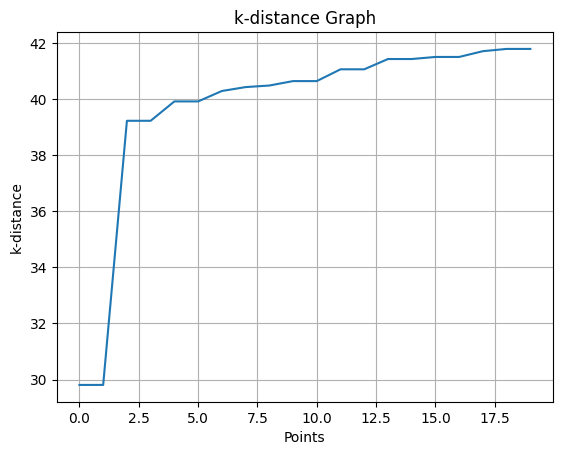

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(x)
distances, indices = nbrs.kneighbors(x)

# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]  # The first column is the point to itself (0 distance)
plt.plot(distances[:20])
plt.xlabel("Points")
plt.ylabel("k-distance")
plt.title("k-distance Graph")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
# Initialize the variables
best_eps = None
best_min_samples = None
best_score = -1
# Example parameter ranges; adjust based on your dataset
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(2, 11)
best_score = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(x)
        labels = db.labels_
        # Silhouette score is only valid if number of clusters is > 1 and not equal to number of samples
        if len(set(labels)) > 1 and len(set(labels)) < len(x):
            score = silhouette_score(x, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

# Make sure that the variables have been set
if best_eps is not None and best_min_samples is not None:
    print(f'Best eps: {best_eps:.2f}, Best min_samples: {best_min_samples:d}, Silhouette Score: {best_score:.4f}')
else:
    print("No valid clustering result was found with the given range of parameters.")

No valid clustering result was found with the given range of parameters.


In [ ]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)  # Adjust eps and min_samples based on your dataset
labels_dbscan = dbscan.fit_predict(x)

# labels_dbscan contains the cluster labels for each poster

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Apply PCA to reduce to 2 dimensions for visualization
pca2 = PCA(n_components=2)
x_pca2 = pca2.fit_transform(feat)

# Assuming 'x' is your data and 'list_k' contains the range of k values you're exploring
k = 10  # Example, select k based on your SSE plot or other criteria
km = KMeans(n_clusters=k, random_state=22, n_init=10)
km.fit(x_pca2)




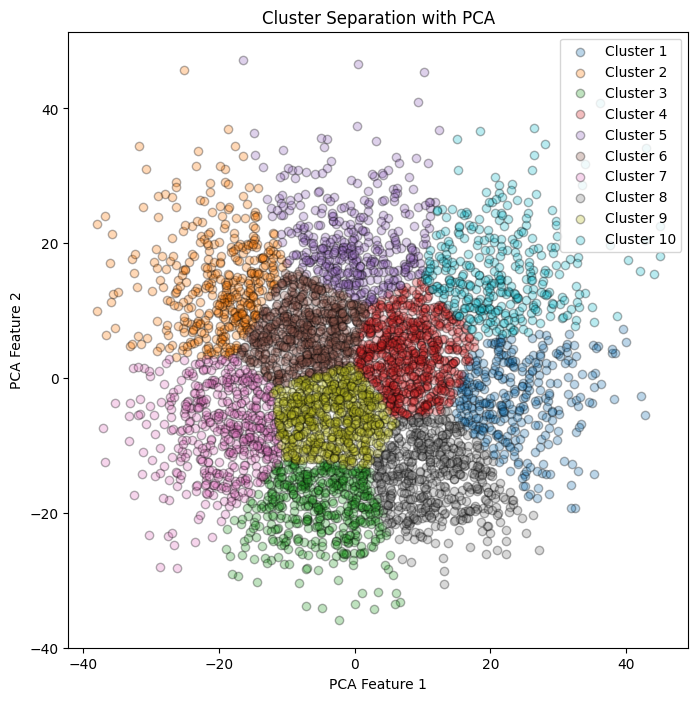

In [ ]:
# Plot the PCA-reduced data, colored by cluster label
plt.figure(figsize=(8, 8))
for i in range(k):
    cluster = x_pca2[km.labels_ == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}', edgecolors='black', alpha=0.3)

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Cluster Separation with PCA')
plt.legend()
plt.show()